# Download data from Encode.
From article : [Principles of RNA processing from analysis of enhanced CLIP maps for 150 RNA binding proteins](https://doi.org/10.1186/s13059-020-01982-9)  
Encode accession: [ENCSR456FVU](https://www.encodeproject.org/publication-data/ENCSR456FVU/).   
[Encode REST API with Python](https://www.encodeproject.org/help/rest-api/#json-script)



In [1]:
import requests
import time
import json
from multiprocessing import Pool, Manager
from IPython.display import clear_output
from functools import reduce
import os

In [2]:
class encode_experiment_downloader():
    '''
    This class constitutes a downloader for the FASTQ files associated with 
    a particular ENCODE eCLIP experiment accession (and corresponding controls).
    Arguments are a string of the ENCODE experiment accession and an optional 
    manager queue for multithreading. Initializing the class creates a folder 
    architecture like so uses the ENCODE REST API to get information about the 
    experiments and create a folder architecture like so:
        ./fastq/
            {cell_line}/
                {accession}_{target}/
                    {eclip_or_control}/
                        {accession}_{target}_rep{n}/
    The number of files to download and total space required are calculated and
    stored in self.num_files and self.total_download_size, respectively.
    Download will not begin until the download_fastqs method is called. The FASTQ 
    files will then be downloaded to the appropriate folder with the filename:
                {accession}_{target}_rep{n}_mate{n}.fastq.gz
    
    TODO: 
    - download barcode for trimming??
    - create txt file with metadata??
    '''
    
    def __init__(self, eclip_encode_accession, queue=None):
        self.eclip_acc = eclip_encode_accession
        self.eclip_json = self.get_json(self.eclip_acc)
        self.get_properties_from_json(self.eclip_json)
        self.create_folder_heirarchy()
        self.file_info_table = {
            "file_accession":[],
            "file_path":[],
            "replicate":[],
            "mate":[],
            "mate_accession":[],
            "experiment_accession":[],
            "target":[],
            "cell_line":[],
            "eclip_experiment_accession":[],
            "experiment_type":[],
            "url":[],
            "file_size":[],
            "barcode_id":[],
            "barcode_sequence":[],
        }
        self.create_table()
        if queue is not None:
            queue.put(self.eclip_acc)

    def get_json(self, encode_exp_accession):
        url = 'https://www.encodeproject.org/experiments/{acc}/'.format(acc=encode_exp_accession)
        response = requests.get(url, headers={'accept': 'application/json'})
        return response.json()
        
    def get_properties_from_json(self, exp_json):
        self.control_accs = [control["accession"] for control in exp_json["possible_controls"]]
        assert len(self.control_accs)==1
        self.ctrl_acc = self.control_accs[0]
        self.ctrl_json = self.get_json(self.ctrl_acc)
        self.ctrl_num_reps = len(self.ctrl_json["replicates"])
        self.ctrl_fastq_files_json = [file for file in self.ctrl_json["files"] if file["file_format"]=="fastq"]
        
        self.cell_line = exp_json["biosample_summary"]
        self.target = exp_json["target"]["label"]
        self.eclip_num_reps = len(exp_json["replicates"])
        self.eclip_fastq_files_json = [file for file in exp_json["files"] if file["file_format"]=="fastq"]
        self.num_files = len(self.eclip_fastq_files_json) + len(self.ctrl_fastq_files_json)
        self.total_download_size = reduce(lambda file_size,file: 
            file_size+int(file["cloud_metadata"]["file_size"]), 
            self.eclip_fastq_files_json+self.ctrl_fastq_files_json, 0)
        
    def create_folder_heirarchy(self):
        self.paths = []
        for rep in range(1,self.eclip_num_reps+1):
            path = "./fastqs/{cell_line}/{exp}_{target}/eclip/{exp}_{target}_rep{rep}".format(cell_line=self.cell_line,
               exp=self.eclip_acc, target=self.target, rep=rep)
            self.paths.append(path)
        for rep in range(1,self.ctrl_num_reps+1):
            path = "./fastqs/{cell_line}/{eclip_exp}_{target}/ctrl/{ctrl_exp}_{target}_rep{rep}".format(cell_line=self.cell_line,
               eclip_exp=self.eclip_acc, ctrl_exp=self.ctrl_acc, target=self.target, rep=rep)
            self.paths.append(path)                                         
        for path in self.paths:
            os.makedirs(path, exist_ok=True)
            
    def create_table(self):
        def add_entries_for_exp(exp_type, file_json_list):
            for file in file_json_list:
                self.file = file
                rep = file["replicate"]["biological_replicate_number"]
                file_exp = file["replicate"]["experiment"]["accession"]
                file_acc = file["accession"]
                mate = file["paired_end"]
                url = file["cloud_metadata"]["url"]
                flowcell_details_len = len(file["flowcell_details"])
                if flowcell_details_len == 0:
                    barcode_id = ""
                    barcode_sequence = ""
                elif flowcell_details_len == 1:
                    barcode_id = file["flowcell_details"][0]["barcode"]
                    barcode_sequence = ""
                else:
                    barcode_id = file["flowcell_details"][0]["barcode"]
                    barcode_sequence = file["flowcell_details"][1]["barcode"]
                file_size = file["cloud_metadata"]["file_size"]
                filepath = ("./fastqs/{cell_line}/{eclip_exp}_{target}/{exp_type}/{exp}_{target}_rep{rep}/"
                                "{file_acc}_{target}_rep{rep}_mate{mate}.fastq.gz").format(cell_line=self.cell_line,
                                eclip_exp=self.eclip_acc, exp=file_exp, target=self.target, rep=rep, 
                                file_acc=file_acc, mate=mate, exp_type=exp_type)
                self.file_info_table["file_accession"].append(file_acc)
                self.file_info_table["file_path"].append(filepath)
                self.file_info_table["file_size"].append(file_size)
                self.file_info_table["replicate"].append(rep)
                self.file_info_table["mate"].append(mate)
                self.file_info_table["mate_accession"].append(file["paired_with"].strip("/").split("/")[-1])
                self.file_info_table["experiment_accession"].append(file_exp)
                self.file_info_table["target"].append(self.target)
                self.file_info_table["cell_line"].append(self.cell_line)
                self.file_info_table["eclip_experiment_accession"].append(self.eclip_acc)
                self.file_info_table["experiment_type"].append(exp_type)
                self.file_info_table["url"].append(url)
                self.file_info_table["barcode_id"].append(barcode_id)
                self.file_info_table["barcode_sequence"].append(barcode_sequence)
        add_entries_for_exp("eclip", self.eclip_fastq_files_json)
        add_entries_for_exp("ctrl", self.ctrl_fastq_files_json)
            
    def download_fastqs(self, queue=None):
        for filepath, url, file_acc in zip(self.file_info_table["file_path"], 
                self.file_info_table["url"], 
                self.file_info_table["file_accession"]):
            with open(filepath, 'wb') as out_file:
                out_file.write(requests.get(url).content)
            if queue is not None:
                queue.put(file_acc)


Accessions list from [Table S1](https://static-content.springer.com/esm/art%3A10.1186%2Fs13059-020-01982-9/MediaObjects/13059_2020_1982_MOESM1_ESM.xlsx)

In [3]:
eclip_accessions = ["ENCSR550DVK", "ENCSR987FTF", "ENCSR744GEU", "ENCSR828ZID", "ENCSR513NDD", "ENCSR993OLA", "ENCSR623VEQ", "ENCSR773KRC", "ENCSR314UMJ", "ENCSR975KIR", "ENCSR267UCX", "ENCSR018ZUE", "ENCSR412NOW", "ENCSR062NNB", "ENCSR351PVI", "ENCSR279UJF", "ENCSR485QCG", "ENCSR655NZA", "ENCSR331VNX", "ENCSR224QWC", "ENCSR365NVO", "ENCSR576SHT", "ENCSR893RAV", "ENCSR456KXI", "ENCSR862QCH", "ENCSR657TZB", "ENCSR154HRN", "ENCSR520BZQ", "ENCSR000SSH", "ENCSR532VUB", "ENCSR307YIW", "ENCSR483NOP", "ENCSR943MHU", "ENCSR202BFN", "ENCSR840DRD", "ENCSR534YOI", "ENCSR006OEQ", "ENCSR240MVJ", "ENCSR328LLU", "ENCSR769UEW", "ENCSR040QLV", "ENCSR057DWB", "ENCSR571VHI", "ENCSR121NVA", "ENCSR919HSE", "ENCSR987NYS", "ENCSR961OKA", "ENCSR989VIY", "ENCSR061EVO", "ENCSR571ROL", "ENCSR432XUP", "ENCSR774RFN", "ENCSR128VXC", "ENCSR755TJC", "ENCSR970NKP", "ENCSR268ETU", "ENCSR295OKT", "ENCSR438KWZ", "ENCSR568DZW", "ENCSR584TCR", "ENCSR947JVR", "ENCSR736AAG", "ENCSR373ODC", "ENCSR339FUY", "ENCSR930BZL", "ENCSR059CWF", "ENCSR628IDK", "ENCSR867DSZ", "ENCSR301UQM", "ENCSR867ZVK", "ENCSR981WKN", "ENCSR739VVT", "ENCSR468FSW", "ENCSR061SZV", "ENCSR265ZIS", "ENCSR861GYE", "ENCSR841EQA", "ENCSR331MIC", "ENCSR861PAR", "ENCSR958FKZ", "ENCSR197INS", "ENCSR038JME", "ENCSR206RXT", "ENCSR965DLL", "ENCSR438GZQ", "ENCSR887LPK", "ENCSR661ICQ", "ENCSR022BVV", "ENCSR658IQB", "ENCSR539ZTS", "ENCSR647CLF", "ENCSR081JYH", "ENCSR887FHF", "ENCSR888YTT", "ENCSR989SMC", "ENCSR456ASB", "ENCSR366YOG", "ENCSR200DKE", "ENCSR734ZHL", "ENCSR018RVZ", "ENCSR570WLM", "ENCSR258QKO", "ENCSR653HQC", "ENCSR999WKT", "ENCSR820WHR", "ENCSR013CTQ", "ENCSR648LAH", "ENCSR786TSC", "ENCSR456JJQ", "ENCSR097NEE", "ENCSR830BSQ", "ENCSR489ABS", "ENCSR993FMY", "ENCSR133QEA", "ENCSR267OLV", "ENCSR663WES", "ENCSR303OQD", "ENCSR819XBT", "ENCSR196INN", "ENCSR001VAC", "ENCSR349CMI", "ENCSR589YHM", "ENCSR120EAR", "ENCSR725ARB", "ENCSR820DQJ", "ENCSR766FAC", "ENCSR543TPH", "ENCSR301TFY", "ENCSR916XIV", "ENCSR277DEO", "ENCSR663NRA", "ENCSR923NKN", "ENCSR529FKI", "ENCSR754NDA", "ENCSR194HZU", "ENCSR815VVI", "ENCSR805SRN", "ENCSR795CAI", "ENCSR891RIC", "ENCSR484LTQ", "ENCSR657TZZ", "ENCSR486YGP", "ENCSR384MWO", "ENCSR834YLD", "ENCSR893EFU", "ENCSR844RVX", "ENCSR506OTC", "ENCSR145NLR", "ENCSR141OIM", "ENCSR135VMS", "ENCSR979EWD", "ENCSR845VGB", "ENCSR668MJX", "ENCSR085JPB", "ENCSR214BZA", "ENCSR349KMG", "ENCSR269AJF", "ENCSR916SRV", "ENCSR488JKQ", "ENCSR825SVO", "ENCSR041NUV", "ENCSR893NWB", "ENCSR490IEE", "ENCSR527DXF", "ENCSR406OOZ", "ENCSR907GUB", "ENCSR970FEW", "ENCSR876EYA", "ENCSR999YGP", "ENCSR023PKW", "ENCSR023UHL", "ENCSR580MFX", "ENCSR647HOX", "ENCSR506UPY", "ENCSR565DGW", "ENCSR921SXC", "ENCSR580OFI", "ENCSR291XPT", "ENCSR606BPV", "ENCSR756CKJ", "ENCSR238CLX", "ENCSR724RDN", "ENCSR001KKZ", "ENCSR154CSN", "ENCSR529GSJ", "ENCSR181NRW", "ENCSR712IAG", "ENCSR202HKN", "ENCSR964VOX", "ENCSR069EVH", "ENCSR308YNT", "ENCSR256CHX", "ENCSR121GQH", "ENCSR464OSH", "ENCSR290VLT", "ENCSR384KAN", "ENCSR177QQY", "ENCSR249ROI", "ENCSR046JHH", "ENCSR361OCV", "ENCSR356ZMO", "ENCSR721HPX", "ENCSR973HOJ", "ENCSR440SUX", "ENCSR922WJV", "ENCSR693JWP", "ENCSR903PRV", "ENCSR539BEV", "ENCSR735HOK", "ENCSR352STY", "ENCSR089BXO", "ENCSR586DGV", "ENCSR356MSW", "ENCSR906ZJF", "ENCSR685AUR", "ENCSR050BDZ", "ENCSR337XGI", "ENCSR484LAB", "ENCSR820UYE", "ENCSR977OXG", "ENCSR322HHA", "ENCSR366DGX", "ENCSR018WPY",]

### Multithreaded Initialization of Downloaders

In [4]:
p = Pool(20)
m = Manager()
q = m.Queue()

args = [(acc, q) for acc in eclip_accessions]
result = p.starmap_async(encode_experiment_downloader, args)

while not result.ready():
    clear_output(wait=True)
    print("Running... {}/{} finished".format(str(q.qsize()), len(eclip_accessions)))
    time.sleep(1)
          
clear_output(wait=True)
outputs = result.get()
p.close()
print("Done! {} finished.".format(len(eclip_accessions)))

Done! 223 finished.


In [5]:
#number of files and space required for download
total_size = reduce(lambda amt, size_obj: amt+size_obj.total_download_size, outputs, 0)
num_files = reduce(lambda amt, size_obj: amt+size_obj.num_files, outputs, 0)
print(num_files, "files, requiring", round(total_size/1024**3, 2), "GB")

1356 files, requiring 698.07 GB


### Multithreaded Downloading of Files

In [ ]:
def download(downloader_instance, q):
    downloader_instance.download_fastqs(q)
    return downloader_instance


p = Pool(12)
m = Manager()
q = m.Queue()


args = [(downloader, q) for downloader in outputs]
result = p.starmap_async(download, args)

while not result.ready():
    clear_output(wait=True)
    print("Running... {}/{} finished downloading".format(str(q.qsize()), num_files))
    time.sleep(1)
          
clear_output(wait=True)
outputs = result.get()
p.close()
print("Done! {} finished.".format(q.qsize()))

In [6]:
from functools import reduce
import pandas as pd
from os.path import getsize

In [7]:
final_dict = {key:[] for key in outputs[0].file_info_table.keys()}
for output in outputs:
    for key in final_dict.keys():
        final_dict[key].extend(output.file_info_table[key])

In [8]:
file_table = pd.DataFrame(data=final_dict)
file_table.set_index("file_accession", inplace=True)
file_table

,barcode_id,barcode_sequence,cell_line,eclip_experiment_accession,experiment_accession,experiment_type,file_path,file_size,mate,mate_accession,replicate,target,url
file_accession,,,,,,,,,,,,,
ENCFF035QUK,A01_B06_UMI5,AUUGCUUAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,659614388,1,ENCFF065BIC,2,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF584MZO,A04_F05_UMI5,ANNNNAAGCTGAGATCGGAAGAGCGTCGTGTAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,846691855,1,ENCFF040BGS,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF040BGS,A04_F05_UMI5,ANNNNGTATCCAGATCGGAAGAGCGTCGTGTAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,929258786,2,ENCFF584MZO,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF065BIC,A01_B06_UMI5,ACAAGCCAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,678149726,2,ENCFF035QUK,2,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF412YDY,none_UMI5,,HepG2,ENCSR550DVK,ENCSR497ANA,ctrl,./fastqs/HepG2/ENCSR550DVK_HNRNPC/ctrl/ENCSR49...,456955797,1,ENCFF357SNM,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF357SNM,none_UMI5,,HepG2,ENCSR550DVK,ENCSR497ANA,ctrl,./fastqs/HepG2/ENCSR550DVK_HNRNPC/ctrl/ENCSR49...,429903776,2,ENCFF412YDY,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF591SSP,C01_D08fixed_UMI5,AACUUGUAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR987FTF,ENCSR987FTF,eclip,./fastqs/HepG2/ENCSR987FTF_RBFOX2/eclip/ENCSR9...,329966162,1,ENCFF289OFA,2,RBFOX2,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF172GUS,A01_B06_UMI5,AUUGCUUAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR987FTF,ENCSR987FTF,eclip,./fastqs/HepG2/ENCSR987FTF_RBFOX2/eclip/ENCSR9...,328684234,1,ENCFF647KDW,1,RBFOX2,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF647KDW,A01_B06_UMI5,ACAAGCCAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR987FTF,ENCSR987FTF,eclip,./fastqs/HepG2/ENCSR987FTF_RBFOX2/eclip/ENCSR9...,350864310,2,ENCFF172GUS,1,RBFOX2,https://encode-public.s3.amazonaws.com/2016/03...


In [ ]:
# to get ones that file_size doesn't match the expected file_size
redownload_list = []
file_accs = []
for idx, row in file_table.iterrows():
    path = row["file_path"]
    size = row["file_size"]
    disk_size = getsize(path)
    if disk_size != size:
        print(idx, size, disk_size)
        redownload_list.append(row["eclip_experiment_accession"])
        file_accs.append(idx)

# Download fasta of human rRNAs
from refseq Gene  
5s: https://www.ncbi.nlm.nih.gov/gene/100169758  
18s: https://www.ncbi.nlm.nih.gov/gene/100008588  
5.8s: https://www.ncbi.nlm.nih.gov/gene/100008587  
28s: https://www.ncbi.nlm.nih.gov/gene/100008589  

In [ ]:
import os
os.mkdir("hisat2_index_hsrRNA")

Make hisat2 index:  
```bash
hisat2-build /home/anthony/yeo_eclip_analysis/hsrRNA.fa /home/anthony/yeo_eclip_analysis/hisat2_index_hsrRNA/
```

## Unzipping

In [79]:
from multiprocessing import Pool, Manager
from subprocess import Popen
import threading
import os
import re
import pandas as pd

In [ ]:
os.makedirs("./logs/decompressing/", exist_ok=True)
os.makedirs("./logs/trimming/", exist_ok=True)

In [ ]:
def gunzip(filepath, q=None):
    '''Decompress gzipped files.
    '''
    exp_folder = filepath.split("/")[-2] 
    p = Popen([
        "gzip",
        "-d",
        filepath
    ], stdout=open("./logs/decompressing/"+exp_folder+".txt", "w"))
    p.wait()
    fname = filepath.split("/")[-1].split("_")[0]
    if q is not None:
        q.put(filepath)
    return (fname, filepath.split(".")[-3]+".fastq")

In [ ]:
filenames = file_table.file_path.values

p = Pool(90) 
m = Manager()
q = m.Queue()

args = [(filename,q) for filename in filenames]

result = p.starmap_async(gunzip, args)

while not result.ready():
    clear_output(wait=True)
    print("Running... {}/{}".format(str(q.qsize()), len(filenames)))
    time.sleep(1)
    
p.close()

clear_output(wait=True)
print("Done. {}/{} processed.".format(str(q.qsize()), len(filenames)))

In [ ]:
# update file paths
file_table["file_path"] = file_table.file_path.str.slice(0,-3)

## Trim reads

In [297]:
import re

In [300]:
def trim_reads(filepath_mate1, filepath_mate2, q = None):
    '''Trim adapters and low quality regions from reads using bbduk.sh
    from the BBTools suite.
    '''
    exp_folder = filepath_mate1.split("/")[-2] 
    outpath_mate1 = re.search("(.*)\.fastq", filepath_mate1).group(1)+"_trimmed.fastq"
    outpath_mate2 = re.search("(.*)\.fastq", filepath_mate2).group(1)+"_trimmed.fastq"
    p = Popen([
        "bbduk.sh",
        "in="+filepath_mate1,
        "in2="+filepath_mate2,
        "out="+outpath_mate1,
        "out2="+outpath_mate2,
        #"refstats="+"~/crac_analysis/trimming_stats/"+filename+".txt",
        "literal=AGATCGGAAGAGCACACGTCTGAACTCCAGTCA,AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT,AACTTGTAGATCGGAAGA",
        "k=33", # this parameter sets the minimum kmer being trimmed. 
                              #Longer = more specific, shorter = more sensitive
        "mink=15", #includes truncations of the kmers down to 8
        "mm=f", #do not ignore middle base mismatch of kmer
        "rcomp=t", #do not allow reverse complement kmer matches
        "copyundefined=t",
        "ktrim=r",
        #"forcetrimleft=12", #removes random barcode on left of reads. FUCK shouldn't have done this
        "minavgquality=10",
        "minlength=10",
        "threads="+"1",
        "overwrite=t",
        "t=1", #prevents each instance from using more than one thread.
    ], stderr=open("./logs/trimming/"+exp_folder+".txt", "w"))
    p.wait()
    if q is not None:
        q.put(exp_folder)
    fname_mate1 = filepath_mate1.split("/")[-1].split("_")[0]
    fname_mate2 = filepath_mate2.split("/")[-1].split("_")[0]
    return ((fname_mate1, outpath_mate1),(fname_mate2, outpath_mate2))

In [294]:
p = Pool(12) 
m = Manager()
q = m.Queue()

gb = file_table.groupby(["experiment_accession", "replicate"])
args = []
for idx,group in gb:
    for idx,first_mate in group.loc[group.mate=="1"].iterrows():
        mate1_path = first_mate["file_path"]
        mate2_path = group.loc[first_mate["mate_accession"]]["file_path"]
        args.append((mate1_path, mate2_path, q))

result = p.starmap_async(trim_reads, args)

while not result.ready():
    clear_output(wait=True)
    print("Running... {}/{}".format(str(q.qsize()), len(args)))
    time.sleep(1)
    
p.close()
outputs = result.get()
clear_output(wait=True)
print("Done. {}/{} processed.".format(str(q.qsize()), len(args)))

Done. 678/678 processed.


# Don't have log for all of them because the ones with more than one fasta per replicate per mate overwrote the logs from each other

In [303]:
# check that all stderr files have the words "Bases Processed", indicating that the trimming finished.
path = "./logs/trimming/"
file_list = os.listdir(path)
file_list = list(filter(lambda filename: filename.startswith("ENC") and filename.endswith(".txt"), file_list))
#assert len(file_list) == len(file_table)/2
file_acc_list = []
for filename in file_list:
    file_acc_list.append(filename.split("_")[0])
    finished = False
    with open(path+filename, "r") as file:
        try:
            for line in file.readlines():
                if "Bases Processed" in line:
                    finished = True
        except:
            print(filename)
            raise
    if not finished:
        print(filename, "did not finish.")
print("Done.")

Done.


In [326]:
#update file_table with new filepaths
new_paths = []
for entry in outputs:
    for file in entry:
        new_paths.append(file)

new_paths = list(zip(*new_paths))
new_paths = pd.Series(data=new_paths[1], index=new_paths[0])
file_table.file_path = new_paths

## Alignment

In [333]:
import os
from multiprocessing import Pool, Manager
from subprocess import Popen
from IPython.display import clear_output
import re
from collections import namedtuple
%matplotlib inline

In [334]:
os.makedirs("./aligned_reads/sam", exist_ok=True)
os.makedirs("./logs/alignment", exist_ok=True)

In [335]:
def align_reads(outsam_name, filepaths_mate1, filepaths_mate2, q = None):
    mate1_file_accs = []
    mate2_file_accs = []
    for filepath in filepaths_mate1:
        mate1_match = re.search("/(ENC[A-Z0-9]{8})_([A-Z0-9-.]*)_(rep[1-9])_mate1_trimmed.fastq", filepath)
        mate1_file_accs.append(mate1_match.group(1))
    for filepath in filepaths_mate2:
        mate2_match = re.search("/(ENC[A-Z0-9]{8})_([A-Z0-9-.]*)_(rep[1-9])_mate2_trimmed.fastq", filepath)
        mate2_file_accs.append(mate2_match.group(1))
    p = Popen([
        "hisat2",
        "-p", "1"
        "-x", "./hisat2_index_hsrRNA/",
        "-1", ",".join(filepaths_mate1),
        "-2", ",".join(filepaths_mate2),
        "-k", "1",
        "-S", "./aligned_reads/sam/"+outsam_name
    ], stderr=open("./logs/alignment/"+outsam_name+"_stderr.txt", "w"))
    p.wait()
    if q is not None:
        q.put(outsam_name)
    return (mate1_file_accs, mate2_file_accs, "./aligned_reads/sam/"+outsam_name)

In [338]:
p = Pool(70) 
m = Manager()
q = m.Queue()

gb = file_table.groupby(["experiment_accession", "replicate"])
args = []
for acc_rep_idx,group in gb:
    experiment_acc, rep = acc_rep_idx
    mate1_paths = []
    mate2_paths = []
    target = group.target.unique()[0]
    for idx,first_mate in group.loc[group.mate=="1"].iterrows():
        mate1_path = first_mate["file_path"]
        mate2_path = group.loc[first_mate["mate_accession"]]["file_path"]
        mate1_paths.append(mate1_path)
        mate2_paths.append(mate2_path)
    outsam_name = "{}_{}_rep{}.sam".format(experiment_acc, target, rep)
    args.append((outsam_name, mate1_paths, mate2_paths, q))

result = p.starmap_async(align_reads, args)

while not result.ready():
    clear_output(wait=True)       
    print("Running... {}/{}".format(str(q.qsize()), len(args)))
    time.sleep(1)
    
p.close()

clear_output(wait=True)
print("Done. {}/{} processed.".format(str(q.qsize()), len(args)))

Done. 669/669 processed.


In [339]:
path = "./logs/alignment/"

file_list = os.listdir(path)
file_list = list(filter(lambda filename: filename.endswith("stderr.txt"), file_list))
assert len(file_list) == 669

num_reads_dict = {}
counter = 0
for filename in file_list:
    finished = False
    with open(path+filename, "r") as file:
        for line in file.readlines():
            match = re.search("\s{4}(\d*) \([\d\.]{4,6}%\) aligned exactly 1 time", line)
            if match:
                num_reads_dict[filename.split(".")[0]] = match.group(1)
                finished = True
    if not finished:
        print(filename, "did not finish.")
        counter += 1
print(str(counter)+"/669 unfinished.")
print("Done")
                

0/669 unfinished.
Done


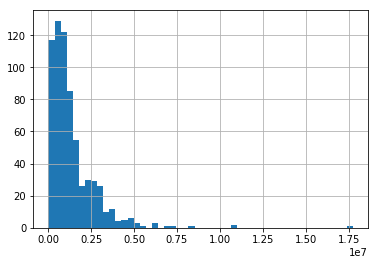

In [340]:
distrib_of_alignment_reads = pd.DataFrame(num_reads_dict, index=["Number of Reads"]).T
distrib_of_alignment_reads["Number of Reads"].astype(float).hist(bins=50)

## Convert SAM to BAM, filter, sort and index

In [341]:
import pysam
from subprocess import Popen
from threading import Thread
from multiprocessing import Pool
from IPython.display import clear_output
from time import sleep
import threading
import os
import re

In [342]:
os.makedirs("./logs/converting", exist_ok=True)
os.makedirs("./logs/sorting", exist_ok=True)
os.makedirs("./logs/indexing", exist_ok=True)

os.makedirs("./aligned_reads/bam_unsorted", exist_ok=True)
os.makedirs("./aligned_reads/bam_sorted", exist_ok=True)

In [343]:
class convert_sort_index():
    def __init__(self, filename, q1, q2, q3):
        self.filename = filename
        global killflag
        self.steps = [ #this is upside down because .pop() starts with the bottom. 
            (self.index_bam, (self.filename, q3)),
            (self.sort_bam, (self.filename, q2)),
            (self.sam_to_bam, (self.filename, q1)),
        ]
        while killflag == False and len(self.steps) > 0:
            fn_name, fn_args = self.steps.pop()
            fn_name(*fn_args)
            #self.check_process(p)
    
    def sam_to_bam(self, filename, q1):
        p = Popen([
            "samtools", "view",
            "-b",
            "-q", "1",
            "-o", "./aligned_reads/bam_unsorted/"+filename.split(".")[0]+".bam",
            "./aligned_reads/sam/"+filename
        ], stderr=open("./logs/converting/"+filename+"_stderr.txt", "w"), 
            stdout=open("./logs/converting/"+filename+"_stdout.txt", "w"),
            preexec_fn=os.setsid)
        p.wait()
        q1.put(filename)
    
    def sort_bam(self, filename, q2):
        p = Popen([
            "samtools", "sort",
            "-o", "./aligned_reads/bam_sorted/"+filename.split(".")[0]+"_sorted.bam",
            "./aligned_reads/bam_unsorted/"+filename.split(".")[0]+".bam",
        ], stderr=open("./logs/sorting/"+filename+"_stderr.txt", "w"), 
            stdout=open("./logs/sorting/"+filename+"_stdout.txt", "w"),
            preexec_fn=os.setsid)
        p.wait()
        q2.put(filename)
        
    def index_bam(self, filename, q3):
        p = Popen([
            "samtools", "index",
            "./aligned_reads/bam_sorted/"+filename.split(".")[0]+"_sorted.bam",
        ], stderr=open("./logs/indexing/"+filename+"_stderr.txt", "w"), 
            stdout=open("./logs/indexing/"+filename+"_stdout.txt", "w"),
            preexec_fn=os.setsid)
        p.wait()
        q3.put(filename)
    
    def check_process(self, process):
        if type(process) == Popen:
            while process.poll() == None:
                if killflag:
                    process.terminate()
            

In [ ]:
file_list = os.listdir("./aligned_reads/sam/")
file_list = list(filter(lambda filename: filename.startswith("ENC"), file_list))
assert len(file_list) == 669

m = Manager()
q1 = m.Queue()
q2 = m.Queue()
q3 = m.Queue()

args = [(filename, q1, q2, q3) for filename in file_list]

killflag = False
p = Pool(90)
map_out = p.starmap_async(convert_sort_index, args)
p.close()

while not map_out.ready():
    clear_output(wait=True)
    print("Pipeline running...\n"
            +"\tConverting {}/{}\n".format(q1.qsize(), len(file_list))
            +"\tSorting {}/{}\n".format(q2.qsize(), len(file_list))
            +"\tIndexing {}/{}".format(q3.qsize(), len(file_list))
         )
    sleep(1)

clear_output(wait=True)
if map_out.successful():
    print("Pipeline completed successfully!")
else:
    print("Pipeline completed with errors.")
print("\tConverting {}/{}".format(q1.qsize(), len(file_list)))
print("\tSorting {}/{}".format(q2.qsize(), len(file_list)))
print("\tIndexing {}/{}".format(q3.qsize(), len(file_list)))
if not map_out.successful():
    map_out.get()


Pipeline running...
	Converting 428/669
	Sorting 421/669
	Indexing 420/669


In [245]:
a = file_table.target.unique()

In [246]:
a.sort()

In [247]:
a

array(['AARS', 'AATF', 'ABCF1', 'AGGF1', 'AKAP1', 'AKAP8L', 'APOBEC3C',
       'AQR', 'BCCIP', 'BCLAF1', 'BUD13', 'CDC40', 'CPEB4', 'CPSF6',
       'CSTF2', 'CSTF2T', 'DDX21', 'DDX24', 'DDX3X', 'DDX42', 'DDX51',
       'DDX52', 'DDX55', 'DDX59', 'DDX6', 'DGCR8', 'DHX30', 'DKC1',
       'DROSHA', 'EFTUD2', 'EIF3D', 'EIF3G', 'EIF3H', 'EIF4G2', 'EWSR1',
       'EXOSC5', 'FAM120A', 'FASTKD2', 'FKBP4', 'FMR1', 'FTO', 'FUBP3',
       'FUS', 'FXR1', 'FXR2', 'G3BP1', 'GEMIN5', 'GNL3', 'GPKOW', 'GRSF1',
       'GRWD1', 'GTF2F1', 'HLTF', 'HNRNPA1', 'HNRNPC', 'HNRNPK', 'HNRNPL',
       'HNRNPM', 'HNRNPU', 'HNRNPUL1', 'IGF2BP1', 'IGF2BP2', 'IGF2BP3',
       'ILF3', 'KHDRBS1', 'KHSRP', 'LARP4', 'LARP7', 'LIN28B', 'LSM11',
       'MATR3', 'METAP2', 'MTPAP', 'NCBP2', 'NIP7', 'NIPBL', 'NKRF',
       'NOL12', 'NOLC1', 'NONO', 'NPM1', 'NSUN2', 'PABPC4', 'PABPN1',
       'PCBP1', 'PCBP2', 'PHF6', 'POLR2G', 'PPIG', 'PPIL4', 'PRPF4',
       'PRPF8', 'PTBP1', 'PUM1', 'PUM2', 'PUS1', 'QKI', 'RBFOX2', 'RBM15'

In [256]:
file_table[file_table.target == "WDR43"]

,cell_line,eclip_experiment_accession,experiment_accession,experiment_type,file_path,file_size,mate,mate_accession,replicate,target,url
file_accession,,,,,,,,,,,
ENCFF083HOA,K562,ENCSR349CMI,ENCSR349CMI,eclip,./fastqs/K562/ENCSR349CMI_WDR43/eclip/ENCSR349...,610203954,1,ENCFF188RTW,2,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF899IIA,K562,ENCSR349CMI,ENCSR349CMI,eclip,./fastqs/K562/ENCSR349CMI_WDR43/eclip/ENCSR349...,562036918,1,ENCFF522XKE,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF522XKE,K562,ENCSR349CMI,ENCSR349CMI,eclip,./fastqs/K562/ENCSR349CMI_WDR43/eclip/ENCSR349...,542945691,2,ENCFF899IIA,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF188RTW,K562,ENCSR349CMI,ENCSR349CMI,eclip,./fastqs/K562/ENCSR349CMI_WDR43/eclip/ENCSR349...,596233249,2,ENCFF083HOA,2,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF855XKN,K562,ENCSR349CMI,ENCSR404ABA,ctrl,./fastqs/K562/ENCSR349CMI_WDR43/ctrl/ENCSR404A...,592869236,1,ENCFF407AXQ,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF407AXQ,K562,ENCSR349CMI,ENCSR404ABA,ctrl,./fastqs/K562/ENCSR349CMI_WDR43/ctrl/ENCSR404A...,545628397,2,ENCFF855XKN,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF503AHN,HepG2,ENCSR085JPB,ENCSR085JPB,eclip,./fastqs/HepG2/ENCSR085JPB_WDR43/eclip/ENCSR08...,509213856,1,ENCFF133XVB,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF577MTW,HepG2,ENCSR085JPB,ENCSR085JPB,eclip,./fastqs/HepG2/ENCSR085JPB_WDR43/eclip/ENCSR08...,505079968,1,ENCFF291FNE,2,WDR43,https://encode-public.s3.amazonaws.com/2018/04...
ENCFF133XVB,HepG2,ENCSR085JPB,ENCSR085JPB,eclip,./fastqs/HepG2/ENCSR085JPB_WDR43/eclip/ENCSR08...,558712974,2,ENCFF503AHN,1,WDR43,https://encode-public.s3.amazonaws.com/2018/04...


In [this protocol](https://www.encodeproject.org/documents/3b1b2762-269a-4978-902e-0e1f91615782/@@download/attachment/eCLIP_analysisSOP_v2.0.pdf),
they say that they use read names to deduplicate pcr artifacts. The random-mer is already removed.

In [10]:
file_table[file_table.experiment_accession == "ENCSR550DVK"]

,barcode_id,barcode_sequence,cell_line,eclip_experiment_accession,experiment_accession,experiment_type,file_path,file_size,mate,mate_accession,replicate,target,url
file_accession,,,,,,,,,,,,,
ENCFF035QUK,A01_B06_UMI5,AUUGCUUAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,659614388,1,ENCFF065BIC,2,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF584MZO,A04_F05_UMI5,ANNNNAAGCTGAGATCGGAAGAGCGTCGTGTAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,846691855,1,ENCFF040BGS,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF040BGS,A04_F05_UMI5,ANNNNGTATCCAGATCGGAAGAGCGTCGTGTAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,929258786,2,ENCFF584MZO,1,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...
ENCFF065BIC,A01_B06_UMI5,ACAAGCCAGAUCGGAAGAGCGUCGUGUAG,HepG2,ENCSR550DVK,ENCSR550DVK,eclip,./fastqs/HepG2/ENCSR550DVK_HNRNPC/eclip/ENCSR5...,678149726,2,ENCFF035QUK,2,HNRNPC,https://encode-public.s3.amazonaws.com/2016/03...


# analysis started again 20200827
## Filter reads for length and mismatch
Keep reads with mismatch <= 1 and with alignment length >= 20

In [264]:
import pysam
import re
import os
from multiprocessing import Pool

In [265]:
def filter_reads(filename):
    in_bam = pysam.AlignmentFile("./aligned_reads/BAMs/sorted/"+filename, "rb")
    out_bam = pysam.AlignmentFile("./aligned_reads/BAMs/filtered/"+filename, "wb", template=in_bam)
    reads = in_bam.fetch(contig="NR_003278.3",start=1,stop=1869)
    num_reads_filtered = 0
    try:
        for count, read in enumerate(reads):
            #alignment_length = read.query_alignment_length
            MD = read.get_tag("MD")
            if (not re.search("[AGCT][\d^]*[AGCT]", MD) and 
                    read.query_alignment_length >= 20 and 
                    read.query_alignment_length == read.reference_length):
                out_bam.write(read)
            else:
                num_reads_filtered += 1
    except:
        print(filename)
        raise
    with open("./aligned_reads/BAMs/temp_files/filtering/"+filename+".txt", "w") as file:
        file.write(str(num_reads_filtered)+" of "+str(count+1)+" ("+str(num_reads_filtered/count*100)+"%) filtered.")
    

In [266]:
file_list = os.listdir("./aligned_reads/BAMs/sorted/")
file_list = list(filter(lambda filename: filename.endswith("bam"), file_list))
assert len(file_list) == 98

p = Pool(90)
try:
    p.map(filter_reads, file_list)
except:
    p.terminate()
    p.close()
    raise
    
print("done")

done


In [267]:
path = "./aligned_reads/BAMs/temp_files/filtering/"
file_list = os.listdir(path)
file_list = list(filter(lambda filename: filename.startswith("SRR") and filename.endswith(".txt"), file_list))
assert len(file_list) == 98

for filename in file_list:
    failed = True
    with open(path+filename, "r") as file:
        for line in file.readlines():
            if re.search("\d* of \d* \([0-9.%]*\) filtered.", line):
                failed = False
    if failed:
        print(test, filename)

print("Done.")

Done.


# Index filtered reads

In [268]:
def index_filtered_bam(filename):
        p = Popen([
            "samtools", "index",
            "/home/anthony/crac_analysis/aligned_reads/BAMs/filtered/"+filename,
        ], stderr=open("./aligned_reads/BAMs/temp_files/indexing_filtered/"+filename+"_stderr.txt", "w"), 
            stdout=open("./aligned_reads/BAMs/temp_files/indexing_filtered/"+filename+"_stdout.txt", "w"),
            preexec_fn=os.setsid)
        p.wait()

In [269]:
file_list = os.listdir("./aligned_reads/BAMs/filtered/")
file_list = list(filter(lambda filename: filename.startswith("SRR") and filename.endswith(".bam"), file_list))
assert len(file_list) == 98

'''
killflag = False
thread_dict = {}
for filename in file_list:
    thread_dict[filename] = Thread(target=convert_sort_index, args=(filename,), name=filename)
    thread_dict[filename].start()
'''
       
p = Pool(90)
try:
    p.map(index_filtered_bam, file_list)
except:
    p.terminate()
p.close()

In [9]:
path = "./aligned_reads/BAMs/temp_files/indexing_filtered/"
file_list = os.listdir(path)
file_list = list(filter(lambda filename: filename.startswith("SRR") and filename.endswith("stderr.txt"), file_list))
assert len(file_list) == 98

for filename in file_list:
    failed = False
    with open(path+filename, "r") as file:
        for line in file.readlines():
            if line != "" and not re.search("\[bam_sort_core\] merging from \d* files and \d* in-memory blocks...", line):
                failed = True
    if failed:
        print(test, filename)
print("Done.")

FileNotFoundError: [Errno 2] No such file or directory: './aligned_reads/BAMs/temp_files/indexing_filtered/'

## Pile up reads and normalize

In [11]:
#1870 nt
import pysam
import os
import re
import threading
from multiprocessing import Pool
import pandas as pd
import numpy as np
import pickle

In [13]:
# get list of total reads
path = "./logs/alignment/" #"./aligned_reads/BAMs/temp_files/filtering/"
file_list = os.listdir(path)
#file_list = list(filter(lambda filename: filename.endswith("bam.txt"), file_list))
file_list = list(filter(lambda filename: filename.endswith("stderr.txt"), file_list))
#assert len(file_list) == 98

num_reads_dict = {}
for filename in file_list:
    finished = False
    with open(path+filename, "r") as file:
        for line in file.readlines():
            match = re.search("^(\d*) reads; of these:", line) #3634 of 2979650 (0.121960632960247%) filtered.
            #match = re.search("^(\d*) of (\d*) \([0-9.%]*\) filtered.", line)
            if match:
                num_reads_dict[filename.split(".")[0]] = int(match.group(1))
                #num_reads_dict[filename.split("_")[0]] = int(match.group(2)) - int(match.group(1))
                finished = True
                continue
    if not finished:
        print(filename, "did not finish.")

print("Done")
                

Done


In [273]:
'''#this is shitty and didn't work because samtools.pileup is a fucking mystery.
def get_pileup(file_path):
    global num_reads_dict
    samfile = pysam.AlignmentFile(file_path, "rb")
    pileup = samfile.pileup("NR_003278.3",0,163) 
    sample_name = re.search("(SRR\d{7})", file_path).group(1)
    pos_depth_list = [(column.reference_pos, column.nsegments) for column in pileup]
    if len(pos_depth_list) != 0:
        pos_depth_list = list(zip(*pos_depth_list))
        pos_depth_list = pd.Series(data=pos_depth_list[1], index=pos_depth_list[0])
        #pos_depth_list = pos_depth_list/num_reads_dict[sample_name]*10**6
    else:
        pos_depth_list = pd.Series()
    return (sample_name, pos_depth_list)
'''

def get_pileup(file_path):
    global num_reads_dict
    samfile = pysam.AlignmentFile(file_path, "rb")
    
    sample_name = re.search("(ENCSR[0-9A-Z])_", file_path).group(1)
    pos_depth_list = pd.DataFrame([*samfile.count_coverage("NR_003278.3",0,1870,quality_threshold=0)]).sum().T
    if len(pos_depth_list) != 0:
        pos_depth_list = pos_depth_list/num_reads_dict[sample_name]*10**6
    else:
        pos_depth_list = pd.Series()
    return (sample_name, pos_depth_list)

In [274]:
path = "./aligned_reads/BAMs/filtered/"
file_list = os.listdir(path)
file_list = list(filter(lambda filename: filename.endswith(".bam"), file_list))
path_file_list = [path+filename for filename in file_list]
assert len(file_list) == 98

p = Pool(90)
try:
    map_list = p.map(get_pileup, path_file_list)
except:
    p.terminate()
    p.close()
    raise

In [275]:
map_unzip = list(zip(*map_list))
pileup_data = pd.concat(map_unzip[1], axis=1)
pileup_data.columns = map_unzip[0]
pileup_data.fillna(0, inplace=True)

In [286]:
# test
x = get_pileup("./aligned_reads/BAMs/filtered/SRR9659371_aligned_sorted.bam")
y = pileup_data.loc[:,"SRR9659371"]
y = y#[y != 0.0]
x[1].equals(y)

True

In [ ]:
#trying to get a 20 nt sliding window

In [301]:
r = np.arange(-10,11)
d = {}
for i in np.arange(0,1870):
    nums = r+i
    d[i+1] = nums[(nums >= 0) & (nums <= 1869)]

In [302]:
out_table = pd.DataFrame(columns=pileup_data.columns, index = pileup_data.index+1)
for i in d:
    out_table.loc[i] = pileup_data.loc[d[i]].mean().round(0)

In [303]:
out_table.index.name = "20nt_group"
out_table.columns.name = "sample"
out_table.to_csv("./18S_sliding_avg_pileup.csv")

In [287]:
#group by 20nt and average. Last group only contains 10nt
groups = np.arange(1,95,1/20)[0:1870]
groups = np.floor(groups)
pileup_group = pileup_data.groupby(groups)
avg_pileup = pileup_group.mean().round(0)
avg_pileup.index.name = "20nt_group"
avg_pileup.columns.name = "sample"
avg_pileup.to_csv("./18S_average_pileup.csv")

with open("./18S_average_pileup.pkl", "wb") as file:
    pickle.dump(avg_pileup, file)